In [1]:
import pandas as pd
import jieba
import re
import matplotlib
import matplotlib.pyplot as plt
import gensim
from gensim.models import CoherenceModel
from gensim import corpora
import pyLDAvis.gensim_models
import numpy as np

from pymongo import MongoClient
import pymongo

In [2]:
# 使用GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
! nvidia-smi

Thu Jun 23 15:27:31 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.129.06   Driver Version: 470.129.06   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| 45%   57C    P2    80W / 260W |   3044MiB / 11019MiB |     30%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:02:00.0 Off |                  N/A |
| 27%   

# LDA

## 2019 brief paragraph

In [3]:
file_cn = open("../LDA/segment/data/cn_file_brief_paragraph_2019.txt", "r")
cn_lines = file_cn.readlines()

# file_us = open("../MUSE-main/data/us_file_brief_p_paragraph.txt", "r")
# us_lines = file_us.readlines()

In [4]:
cn_desc = [i.replace(" \n","").split(" ") for i in cn_lines]
# us_desc = [i.replace(" \n","").split(" ") for i in us_lines]

In [5]:
id2word = corpora.Dictionary(cn_desc)
print('資料集字典：')
print(id2word)

資料集字典：
Dictionary(17923 unique tokens: ['一个', '之间', '信号传输', '信道', '候选']...)


In [6]:
corpus = [id2word.doc2bow(text) for text in cn_desc]
print('第一篇文章 corpus :')
print(corpus[0][:10])

第一篇文章 corpus :
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 2), (8, 3), (9, 1)]


+ corpus = 文檔語料庫
+ id2word = 詞彙字典
+ num_topics = 生成幾個主題數
+ random_state = 固定亂數值，每次的模型結果會一樣
+ iteration = 每個文章訓練的次數，可以設定高一點讓模型收斂
+ passes(epoch) = 整個 corpus 訓練模型的次數
+ alpha = 文章主題分佈
+ eta = 主題字分佈

In [7]:
topic_num_list = np.arange(2, 26, 1)
result = []
for topic_num in topic_num_list:
    # perplexity
    tmp_ldamodel = gensim.models.ldamulticore.LdaMulticore(
        corpus = corpus,
        num_topics = topic_num ,
        id2word=id2word,
        random_state = 1500,
        passes=5,
        iterations=2000
        )
    tmp_perplexity = tmp_ldamodel.log_perplexity(corpus)
    temp_skleran = np.exp(-1. * tmp_perplexity)
    
    result.append({"topic_num": topic_num, "gensim_perplexity": tmp_perplexity, "perplexity":temp_skleran})
    print(topic_num)

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25


,topic_num,gensim_perplexity,perplexity
0,2,-7.025788,1125.280647
1,3,-7.040142,1141.550222
2,4,-7.046187,1148.471370
3,5,-7.010511,1108.220107
4,6,-6.985308,1080.639087
5,7,-6.925344,1017.744587
6,8,-6.924901,1017.293895
7,9,-6.921344,1013.681405
8,10,-6.915261,1007.533829
9,11,-6.913610,1005.872040


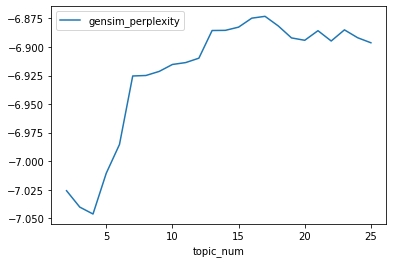

In [8]:
result = pd.DataFrame(result)
result.plot.line(x='topic_num', y='gensim_perplexity', label='gensim_perplexity')
result

,topic_num,gensim_perplexity,perplexity
0,2,-7.025788,1125.280647
1,3,-7.040142,1141.550222
2,4,-7.046187,1148.471370
3,5,-7.010511,1108.220107
4,6,-6.985308,1080.639087
5,7,-6.925344,1017.744587
6,8,-6.924901,1017.293895
7,9,-6.921344,1013.681405
8,10,-6.915261,1007.533829
9,11,-6.913610,1005.872040


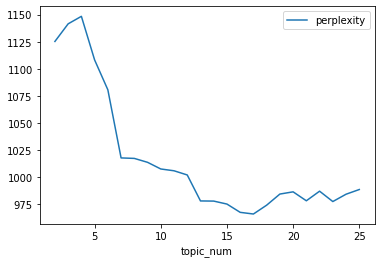

In [9]:
result = pd.DataFrame(result)
result.plot.line(x='topic_num', y='perplexity', label='perplexity')
result

In [10]:
# 儲存LDA_result
result.to_csv("./result/LDA_cn_brief_paragraph_2019.csv", index=False)

## priority description sentence

In [11]:
# file_cn = open("../MUSE-main/data/cn_file_desc_p_s_2500.txt", "r")
# cn_lines = file_cn.readlines()

# file_us = open("../MUSE-main/data/us_file_desc_p_s_2500.txt", "r")
# us_lines = file_us.readlines()

In [12]:
# cn_desc = [i.replace(" \n","").split(" ") for i in cn_lines]
# us_desc = [i.replace(" \n","").split(" ") for i in us_lines]

In [13]:
# id2word = corpora.Dictionary(cn_desc)
# print('資料集字典：')
# print(id2word)

In [14]:
# corpus = [id2word.doc2bow(text) for text in cn_desc]
# print('第一篇文章 corpus :')
# print(corpus[0][:10])

+ corpus = 文檔語料庫
+ id2word = 詞彙字典
+ num_topics = 生成幾個主題數
+ random_state = 固定亂數值，每次的模型結果會一樣
+ iteration = 每個文章訓練的次數，可以設定高一點讓模型收斂
+ passes(epoch) = 整個 corpus 訓練模型的次數
+ alpha = 文章主題分佈
+ eta = 主題字分佈

In [15]:
# topic_num_list = np.arange(2, 20, 2)
# result = []
# for topic_num in topic_num_list:
#     # perplexity
#     tmp_ldamodel = gensim.models.ldamulticore.LdaMulticore(
#         corpus = corpus,
#         num_topics = topic_num ,
#         id2word=id2word,
#         random_state = 1500,
#         passes=5,
#         iterations=2000
#         )
#     tmp_perplexity = tmp_ldamodel.log_perplexity(corpus)
#     temp_skleran = np.exp(-1. * tmp_perplexity)
    
#     result.append({"topic_num": topic_num, "gensim_perplexity": tmp_perplexity, "perplexity":temp_skleran})
#     print(topic_num)

In [16]:
# result = pd.DataFrame(result)
# result.plot.line(x='topic_num', y='gensim_perplexity', label='gensim_perplexity')
# result

In [17]:
# result = pd.DataFrame(result)
# result.plot.line(x='topic_num', y='perplexity', label='perplexity')
# result

In [18]:
# 儲存LDA_result
# result.to_csv("./result/LDA_cn_desc_p_s_2500.csv", index=False)

## 找出文章topic

In [19]:
best_num = result[result.perplexity == min(result.perplexity)]["topic_num"].values[0]

In [20]:
ldamodel = gensim.models.ldamulticore.LdaMulticore(
        corpus = corpus,
        num_topics = best_num ,
        id2word=id2word,
        random_state = 1500,
        passes=5,
        iterations=2000
        )

In [21]:
# 取得每個文章的主題分佈
topics_doc = ldamodel.get_document_topics(corpus, minimum_probability=0.000001) 

In [22]:
c = [i[1] for i in topics_doc[0]]
c.index(max(c)) 

6

In [23]:
topics_cn = [] 
for topics in topics_doc:
    c = [i[1] for i in topics]
    topics_cn.append(c.index(max(c)))

In [24]:
topics_cn

[6,
 13,
 1,
 13,
 9,
 1,
 3,
 9,
 9,
 6,
 1,
 12,
 1,
 1,
 13,
 10,
 10,
 13,
 13,
 9,
 10,
 13,
 9,
 14,
 7,
 14,
 11,
 2,
 14,
 9,
 10,
 6,
 10,
 5,
 7,
 14,
 1,
 13,
 9,
 12,
 9,
 9,
 10,
 14,
 13,
 9,
 13,
 9,
 14,
 1,
 1,
 12,
 8,
 12,
 14,
 1,
 13,
 10,
 7,
 11,
 12,
 13,
 1,
 1,
 10,
 13,
 13,
 10,
 14,
 10,
 1,
 1,
 13,
 13,
 15,
 12,
 4,
 8,
 1,
 12,
 10,
 1,
 10,
 13,
 5,
 8,
 12,
 6,
 6,
 0,
 14,
 9,
 6,
 12,
 9,
 13,
 1,
 13,
 13,
 9,
 7,
 9,
 10,
 13,
 13,
 14,
 13,
 0,
 8,
 13,
 9,
 14,
 14,
 10,
 13,
 13,
 14,
 9,
 1,
 7,
 6,
 9,
 14,
 10,
 5,
 13,
 3,
 5,
 2,
 14,
 14,
 15,
 1,
 5,
 2,
 11,
 14,
 10,
 9,
 6,
 12,
 14,
 13,
 12,
 1,
 13,
 13,
 6,
 15,
 13,
 13,
 10,
 14,
 5,
 3,
 10,
 13,
 13,
 11,
 10,
 8,
 10,
 14,
 9,
 3,
 13,
 14,
 5,
 11,
 14,
 12,
 10,
 10,
 12,
 9,
 14,
 3,
 13,
 14,
 12,
 9,
 13,
 13,
 1,
 14,
 13,
 0,
 6,
 10,
 14,
 1,
 14,
 9,
 12,
 5,
 14,
 12,
 13,
 14,
 14,
 13,
 14,
 13,
 13,
 3,
 1,
 9,
 12,
 3,
 1,
 3,
 10,
 10,
 9,
 13,
 14,
 14,
 10,
 

In [25]:
print(len(topics_cn))
print(len(cn_desc))

7486
7486


## 找出對應的patent編號和公司

In [26]:
mongoURI = "mongodb://%s:%s@%s/%s?authMechanism=SCRAM-SHA-1" % ("eva", "eva_30241", "140.117.69.70:30241", "eva")

try:
    conn = pymongo.MongoClient(mongoURI)
    db = conn.eva
    # db_rm_us = db.rm_patent_us
    # db_rm_cn = db.rm_patent_cn
    # db_rm_de = db.rm_patent_de
    
    # db_rm_us_2019 = db.rm_patent_us_2019
    db_rm_cn_2019 = db.rm_patent_cn_2019
    # db_rm_de_2019 = db.rm_patent_de_2019
except errors.ConnectionFailure as err:
    print(err)

In [27]:
# data_cn_desc = p_db_cn.find({}, {"patentNumber":1, "brief": 1})
data_cn_desc = db_rm_cn_2019.find({}, {"patentNumber":1, "brief": 1, "current_assignee":1})

ls_id = []
ls_pNo = []
ls_com = []
ls_desc = []
for data in data_cn_desc:
    # print(data["_id"],data["count"])
    ls_id.append(data["_id"])
    ls_pNo.append(data["patentNumber"])
    ls_com.append(data["current_assignee"])
    ls_desc.append(data["brief"])
    

In [28]:
# df_cn = pd.DataFrame((zip(ls_id, ls_pNo, ls_desc)), columns = ['id', 'patentNumber', 'brief'])
df_cn = pd.DataFrame((zip(ls_id, ls_pNo, ls_com, ls_desc)), columns = ['id', 'patentNumber', 'company', 'brief'])

In [29]:
df_cn

,id,patentNumber,company,brief
0,61ff22cbf4d57576a5026753,CN112368969A,[Qualcomm Inc],提供了可以在基站和/或用户设备(UE)中使用以帮助确定是否可以在UE之间采用共享的无线电频率...
1,61ffe12ef4d57576a502c4b9,CN110141819A,[Beijing Tangxin Internet Of Things Technology...,本发明实施例公开了一种基于WF‑IoT的物联网消防检测系统、方法及其存储介质，涉及物联网技术...
2,61ffe12ef4d57576a502c4bb,CN210428556U,[Shanghai Institute of Technology],本实用新型公开了一种基于无人机技术的多用途电子安防巡检系统，包括无人机系统和地面信息处理系统...
3,61ffe13bf4d57576a502c4c3,CN110033601A,[Beijing Tangxin Internet Of Things Technology...,本发明实施例公开了一种基于WF‑IoT的物联网消防报警系统和方法，涉及物联网消防技术领域。所...
4,61ffe13ef4d57576a502c4c5,CN110312224A,[Huazhong University of Science and Technology],本发明属于危险化学品存取技术领域，公开了一种实验室危险化学品存取行为的安全防护系统及方法，通...
...,...,...,...,...
7481,620072ebf4d57576a50387f7,CN110070719B,[Hangzhou H3C Technologies Co Ltd],本申请实施例提供了一种通行事件检测方法及装置，涉及信息检测技术领域，其中，上述方法包括：接收...
7482,620072edf4d57576a50387f9,CN110276179B,[Neusoft Corp],本公开涉及一种用户授权的方法、装置、存储介质及电子设备，应用于运维流程中的用户授权，所述方法...
7483,620072eff4d57576a50387fb,CN110557802B,[Huawei Technologies Co Ltd],本申请提供了一种ZigBee终端设备重上线方法及ZigBee终端设备。所述方法包括：ZigB...
7484,620072f0f4d57576a50387fd,CN110972231B,[Cloudminds Robotics Co Ltd],本公开涉及一种配置系统信息的方法、装置、存储介质及网络设备和终端，网络设备可以获取目标终端的...


In [30]:
print(len(df_cn))
print(len(cn_desc))

7486
7486


In [31]:
df_cn["topic"]=topics_cn

In [32]:
df_cn

,id,patentNumber,company,brief,topic
0,61ff22cbf4d57576a5026753,CN112368969A,[Qualcomm Inc],提供了可以在基站和/或用户设备(UE)中使用以帮助确定是否可以在UE之间采用共享的无线电频率...,6
1,61ffe12ef4d57576a502c4b9,CN110141819A,[Beijing Tangxin Internet Of Things Technology...,本发明实施例公开了一种基于WF‑IoT的物联网消防检测系统、方法及其存储介质，涉及物联网技术...,13
2,61ffe12ef4d57576a502c4bb,CN210428556U,[Shanghai Institute of Technology],本实用新型公开了一种基于无人机技术的多用途电子安防巡检系统，包括无人机系统和地面信息处理系统...,1
3,61ffe13bf4d57576a502c4c3,CN110033601A,[Beijing Tangxin Internet Of Things Technology...,本发明实施例公开了一种基于WF‑IoT的物联网消防报警系统和方法，涉及物联网消防技术领域。所...,13
4,61ffe13ef4d57576a502c4c5,CN110312224A,[Huazhong University of Science and Technology],本发明属于危险化学品存取技术领域，公开了一种实验室危险化学品存取行为的安全防护系统及方法，通...,9
...,...,...,...,...,...
7481,620072ebf4d57576a50387f7,CN110070719B,[Hangzhou H3C Technologies Co Ltd],本申请实施例提供了一种通行事件检测方法及装置，涉及信息检测技术领域，其中，上述方法包括：接收...,2
7482,620072edf4d57576a50387f9,CN110276179B,[Neusoft Corp],本公开涉及一种用户授权的方法、装置、存储介质及电子设备，应用于运维流程中的用户授权，所述方法...,6
7483,620072eff4d57576a50387fb,CN110557802B,[Huawei Technologies Co Ltd],本申请提供了一种ZigBee终端设备重上线方法及ZigBee终端设备。所述方法包括：ZigB...,6
7484,620072f0f4d57576a50387fd,CN110972231B,[Cloudminds Robotics Co Ltd],本公开涉及一种配置系统信息的方法、装置、存储介质及网络设备和终端，网络设备可以获取目标终端的...,6


In [33]:
df_cn2 = df_cn.explode('company')
df_cn2

,id,patentNumber,company,brief,topic
0,61ff22cbf4d57576a5026753,CN112368969A,Qualcomm Inc,提供了可以在基站和/或用户设备(UE)中使用以帮助确定是否可以在UE之间采用共享的无线电频率...,6
1,61ffe12ef4d57576a502c4b9,CN110141819A,Beijing Tangxin Internet Of Things Technology ...,本发明实施例公开了一种基于WF‑IoT的物联网消防检测系统、方法及其存储介质，涉及物联网技术...,13
2,61ffe12ef4d57576a502c4bb,CN210428556U,Shanghai Institute of Technology,本实用新型公开了一种基于无人机技术的多用途电子安防巡检系统，包括无人机系统和地面信息处理系统...,1
3,61ffe13bf4d57576a502c4c3,CN110033601A,Beijing Tangxin Internet Of Things Technology ...,本发明实施例公开了一种基于WF‑IoT的物联网消防报警系统和方法，涉及物联网消防技术领域。所...,13
4,61ffe13ef4d57576a502c4c5,CN110312224A,Huazhong University of Science and Technology,本发明属于危险化学品存取技术领域，公开了一种实验室危险化学品存取行为的安全防护系统及方法，通...,9
...,...,...,...,...,...
7481,620072ebf4d57576a50387f7,CN110070719B,Hangzhou H3C Technologies Co Ltd,本申请实施例提供了一种通行事件检测方法及装置，涉及信息检测技术领域，其中，上述方法包括：接收...,2
7482,620072edf4d57576a50387f9,CN110276179B,Neusoft Corp,本公开涉及一种用户授权的方法、装置、存储介质及电子设备，应用于运维流程中的用户授权，所述方法...,6
7483,620072eff4d57576a50387fb,CN110557802B,Huawei Technologies Co Ltd,本申请提供了一种ZigBee终端设备重上线方法及ZigBee终端设备。所述方法包括：ZigB...,6
7484,620072f0f4d57576a50387fd,CN110972231B,Cloudminds Robotics Co Ltd,本公开涉及一种配置系统信息的方法、装置、存储介质及网络设备和终端，网络设备可以获取目标终端的...,6


In [34]:
# 排名前16的公司
c_ls = list(df_cn2.groupby("company",as_index=False).size().sort_values("size",ascending=False).head(16).company)
c_ls

['Huawei Technologies Co Ltd',
 'Shanghai Langbo Communication Technology Co Ltd',
 'NTT Docomo Inc',
 'China Mobile Communications Group Co Ltd',
 'Samsung Electronics Co Ltd',
 'Guangdong Oppo Mobile Telecommunications Corp Ltd',
 'China Mobile IoT Co Ltd',
 'Neusoft Corp',
 'Telefonaktiebolaget LM Ericsson AB',
 'Alibaba Group Holding Ltd',
 'China United Network Communications Group Co Ltd',
 'Shanghai Roye Electric Science and Technology Co Ltd',
 'Xian Irain IoT Technology Service Co Ltd',
 'Apple Inc',
 'State Grid Corp of China SGCC',
 'Beijing ByteDance Network Technology Co Ltd']

### 轉成company-topic 的總數表格

In [35]:
df_cn_count = df_cn2.groupby(["company","topic"],as_index=False).size()
df_cn_count

,company,topic,size
0,3M Innovative Properties Co,14,1
1,63921 Troops of PLA,9,1
2,720 Health Beijing Itech Health Co ltd,12,1
3,A Field Of Shenzhen Science And Technology Co Ltd,9,1
4,ABB Schweiz AG,1,1
...,...,...,...
5254,Zibo Haiyuan Electronic Technology Co ltd,12,1
5255,Ziehl Abegg SE,3,1
5256,Ziguang Zhanrui (chongqing) Technology Co Ltd,3,1
5257,Ziguang Zhanrui (chongqing) Technology Co Ltd,6,1


In [36]:
# 轉成company-topic 的總數表格
table_cn = df_cn_count.pivot_table(index='company', values='size', columns='topic',aggfunc=['sum']).fillna(0).reset_index()
table_cn = table_cn.droplevel(level=0, axis=1)
table_cn = table_cn.rename(columns={'':'company'})

In [37]:
table_cn

topic,company,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,3M Innovative Properties Co,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,63921 Troops of PLA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,720 Health Beijing Itech Health Co ltd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,A Field Of Shenzhen Science And Technology Co Ltd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ABB Schweiz AG,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3637,Zibo Angyang Energy Conservation And Environme...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3638,Zibo Haiyuan Electronic Technology Co ltd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3639,Ziehl Abegg SE,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3640,Ziguang Zhanrui (chongqing) Technology Co Ltd,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
final_table_cn = table_cn[table_cn.company.isin(c_ls)]
final_table_cn

topic,company,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
36,Alibaba Group Holding Ltd,1.0,5.0,9.0,6.0,0.0,7.0,3.0,2.0,0.0,7.0,0.0,0.0,1.0,0.0,21.0,0.0,0.0
114,Apple Inc,0.0,0.0,0.0,0.0,1.0,0.0,33.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,1.0
178,Beijing ByteDance Network Technology Co Ltd,0.0,0.0,0.0,8.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,1.0,0.0
506,China Mobile Communications Group Co Ltd,1.0,10.0,8.0,6.0,5.0,7.0,14.0,5.0,2.0,5.0,1.0,2.0,16.0,8.0,28.0,3.0,3.0
517,China Mobile IoT Co Ltd,0.0,9.0,7.0,4.0,4.0,3.0,2.0,5.0,2.0,5.0,1.0,1.0,15.0,5.0,8.0,3.0,3.0
540,China United Network Communications Group Co Ltd,0.0,2.0,1.0,1.0,0.0,4.0,9.0,3.0,0.0,1.0,2.0,3.0,0.0,4.0,28.0,0.0,2.0
946,Guangdong Oppo Mobile Telecommunications Corp Ltd,0.0,0.0,3.0,1.0,0.0,1.0,88.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,10.0,0.0,0.0
1344,Huawei Technologies Co Ltd,2.0,1.0,7.0,5.0,3.0,3.0,247.0,3.0,2.0,0.0,15.0,0.0,1.0,5.0,113.0,2.0,2.0
1824,NTT Docomo Inc,0.0,0.0,0.0,0.0,0.0,0.0,131.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
1958,Neusoft Corp,1.0,3.0,4.0,7.0,0.0,18.0,14.0,4.0,0.0,0.0,0.0,1.0,1.0,0.0,12.0,0.0,5.0


In [39]:
final_table_cn.shape

(16, 18)

In [40]:
table_cn.to_csv('company_lda_brief_cn_2019.csv',index=0)